# Exploratory Data Analysis

## Environment and Dataset Setup

In [90]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [91]:
# import data from csv
raw = pd.read_csv('data\dataset.csv', encoding='unicode_escape')
raw.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [92]:
# count number of non-blank data points in each column
notna = (raw.notna()).sum()
notna

Patient ID                                               5644
Patient age quantile                                     5644
SARS-Cov-2 exam result                                   5644
Patient addmited to regular ward (1=yes, 0=no)           5644
Patient addmited to semi-intensive unit (1=yes, 0=no)    5644
                                                         ... 
HCO3 (arterial blood gas analysis)                         27
pO2 (arterial blood gas analysis)                          27
Arteiral Fio2                                              20
Phosphor                                                   20
ctO2 (arterial blood gas analysis)                         27
Length: 111, dtype: int64

In [93]:
# function to convert virus test columns to ints
def to_nums(val):
    if val in ('not_detected', 'negative'):
        return 0
    elif val in ('detected', 'positive'):
        return 1
    elif val in ('not_done', ):
        return np.nan
    else:
        return val

In [94]:
# function to standardize data (z-score method)
def norm(col):
    mu = np.mean(col)
    sigma = np.std(col)
    return (col - mu) / sigma

In [95]:
# drop columns with too few data points
df = raw.drop([col for col in raw.columns if notna[col] < 100] + ['Patient ID'], axis=1)
print(f"Dropped {len([col for col in raw.columns if notna[col] < 100])} columns")

# save list of categorical vs continuous variables in a text file
def save_categorical(col):
    if any([val in ('detected', 'not_detected', 'positive', 'negative') for val in col.values]):
        with open('data/categorical-vars.csv', 'a') as f:
            f.write(col.name + ',')
    else:
        with open('data/continuous-vars.csv', 'a') as f:
            f.write(col.name + ',')

df.apply(save_categorical)

# convert data to float values
df = df.applymap(to_nums)

# standardize age quantile data
df['Patient age quantile'] = norm(df['Patient age quantile'])

Dropped 47 columns


In [96]:
# save new dataframe to csv for future use
df.to_csv('data/missing-values.csv')

## Preliminary Exploratory Analysis

In [97]:
# dataset statistics: proof that data is normalized, because µ=0 and σ=1 for all columns with dtype float64)
df_stats = df.describe()

# how many examples of each output we are trying to predict
op_cols = ['SARS-Cov-2 exam result', 'Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 
'Patient addmited to intensive care unit (1=yes, 0=no)']
op_count = {col:df[col].sum() for col in op_cols}

op_count #gives number of positives in each column, negatives can be calculated by subtracting from 5644

{'SARS-Cov-2 exam result': 558,
 'Patient addmited to regular ward (1=yes, 0=no)': 79,
 'Patient addmited to semi-intensive unit (1=yes, 0=no)': 50,
 'Patient addmited to intensive care unit (1=yes, 0=no)': 41}

In [98]:
# create a correlation matrix for the dataset
corr = df.corr()
threshold = corr.applymap(lambda x: x if abs(x) >= 0.3 else 0) # focus on data with a correlation coefficient of > 0.3
covid_corr = corr.iloc[1:5] # to better view which factors correlate with the outputs we are trying to predict

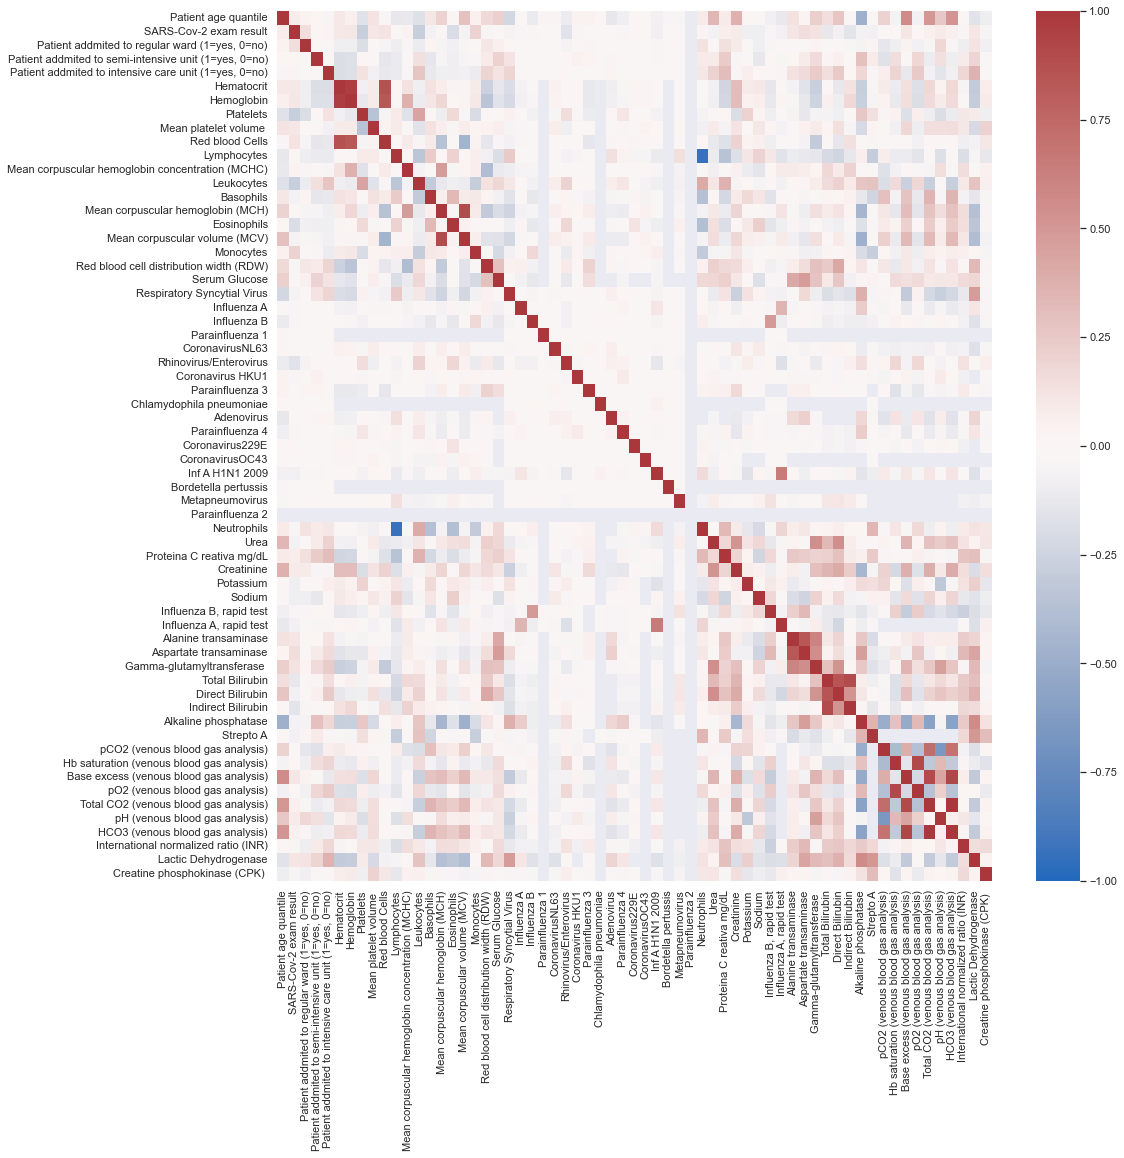

In [99]:
# plot correlation heatmap for whole dataset
fig1 = plt.figure(figsize=(16,16))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='vlag')

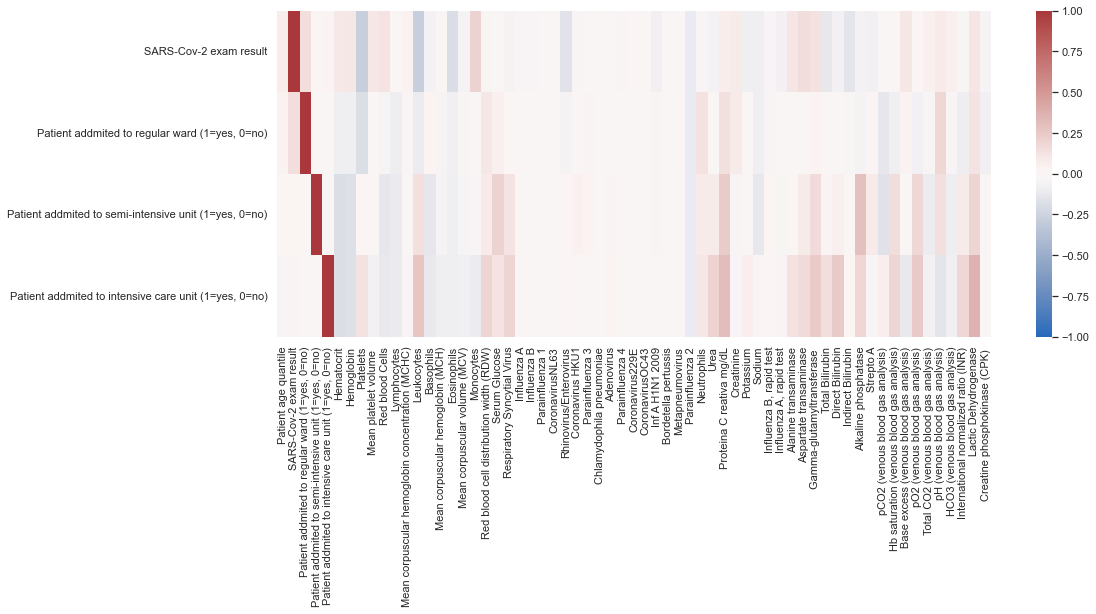

In [100]:
# plot correlation heatmap with focus on COVID outcomes
fig2 = plt.figure(figsize=(16,6))
covid_heatmap = sns.heatmap(covid_corr, vmin=-1, vmax=1, cmap='vlag')